## Task 2

## Setup and Library

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# For reproducibility
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Data Loading and Preprocessing

In [3]:
# Load TSLA data from YFinance
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-10-31'
tsla_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Inspect data
tsla_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500


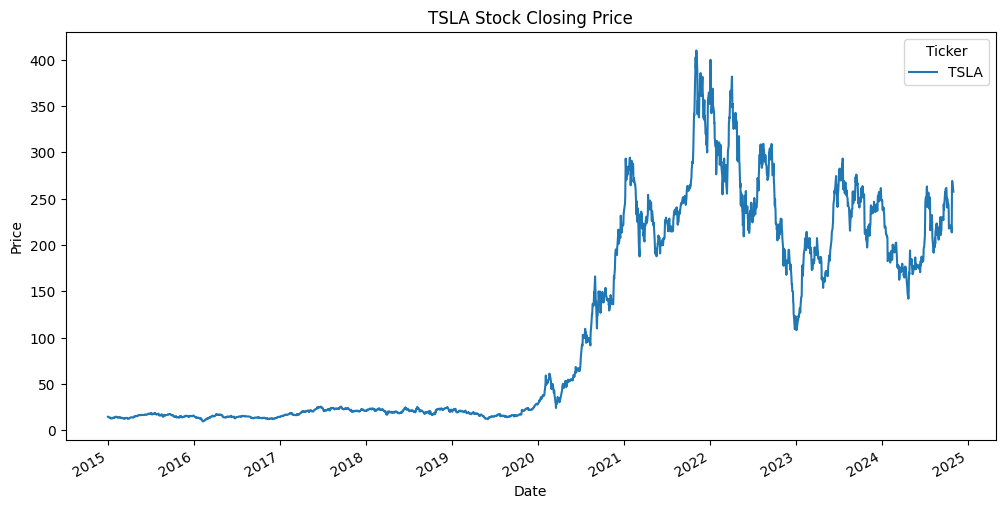

In [5]:
# Stock Closing Price
tsla_data['Close'].plot(figsize=(12, 6), title=f"{ticker} Stock Closing Price", xlabel='Date', ylabel='Price')
plt.show()


## Data Cleaning and Preparation

In [6]:
# Check for missing values
print(tsla_data.isnull().sum())

# Fill missing values (if any)
tsla_data.fillna(method='ffill', inplace=True)

# Extract 'Close' prices and scale
close_prices = tsla_data['Close']

Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


## Train-Test Split

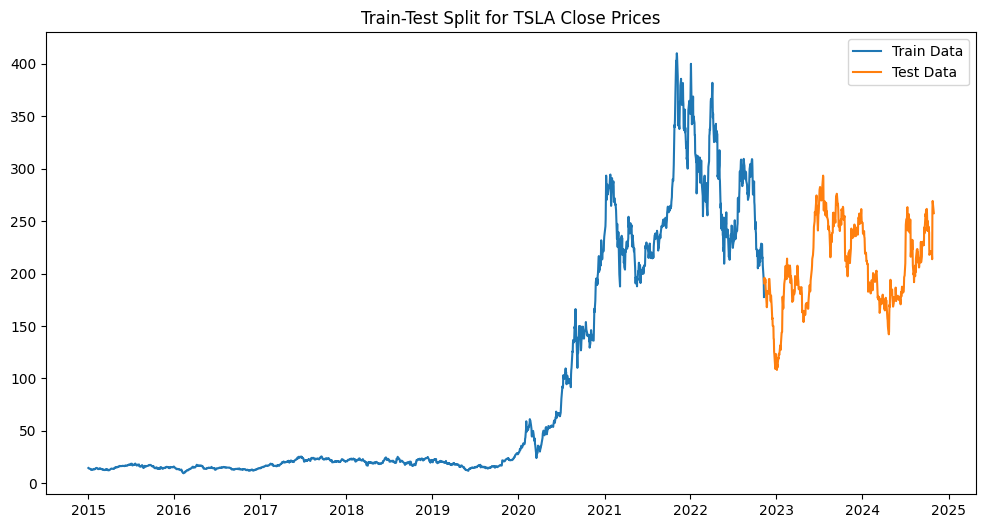

In [7]:
# Define the split ratio
split_ratio = 0.8
train_size = int(len(close_prices) * split_ratio)

# Split the data
train, test = close_prices[:train_size], close_prices[train_size:]
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.legend()
plt.title("Train-Test Split for TSLA Close Prices")
plt.show()


## Model Building and Training

### 1. ARIMA Model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=0.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.203 seconds
Optimal (p, d, q) parameters: (0, 1, 0)


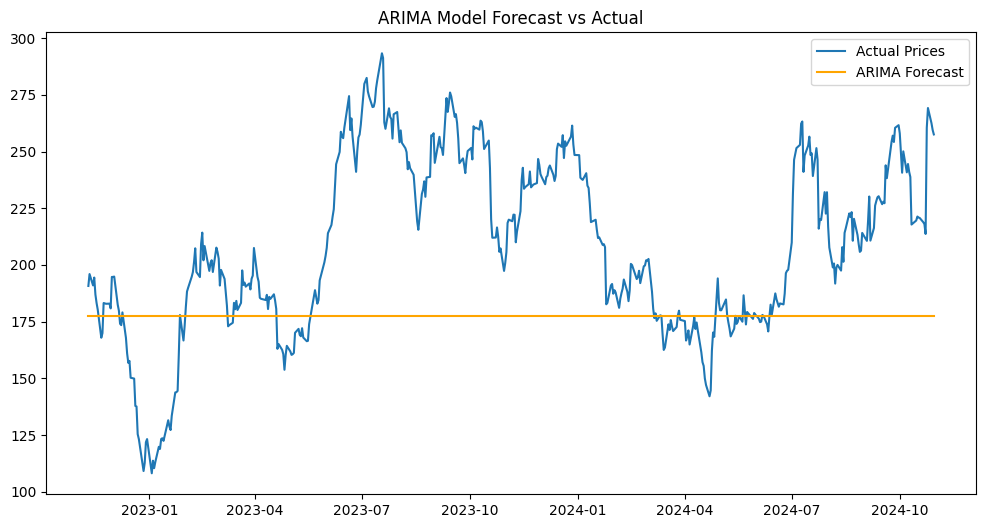

In [8]:
# Automatically find the optimal ARIMA (p, d, q) parameters using auto_arima
arima_model = auto_arima(train, seasonal=False, trace=True)
print(f"Optimal (p, d, q) parameters: {arima_model.order}")

# Fit the ARIMA model
model_arima = ARIMA(train, order=arima_model.order)
model_arima_fit = model_arima.fit()

# Forecast for the test period
arima_forecast = model_arima_fit.forecast(steps=len(test))

# Plot the forecast against the actual prices
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Prices')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title("ARIMA Model Forecast vs Actual")
plt.show()


### 2. SARIMA Model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12337.622, Time=5.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12340.889, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12340.375, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12340.797, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12339.337, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12345.594, Time=4.04 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12345.207, Time=5.14 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=12315.154, Time=18.42 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=12313.154, Time=13.11 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=12311.156, Time=10.65 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=12343.201, Time=3.68 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=12313.155, Time=15.00 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=12335.607, Time=6.60 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=12309.410, Time=6.31 sec
 

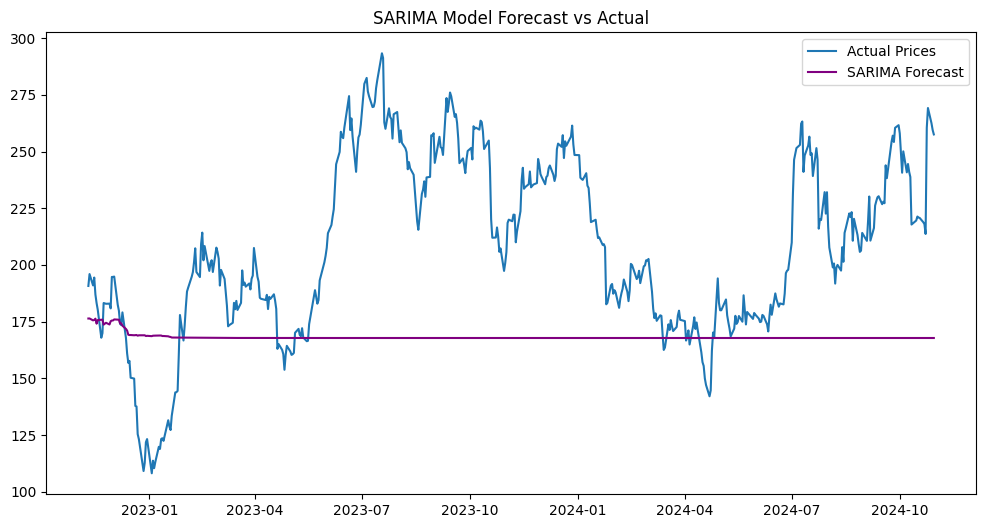

In [9]:
# Automatically find the best SARIMA parameters
sarima_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(f"Optimal SARIMA (p, d, q)x(P, D, Q, m) parameters: {sarima_model.order}x{sarima_model.seasonal_order}")

# Fit the SARIMA model
model_sarima = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
model_sarima_fit = model_sarima.fit(disp=False)

# Forecast for the test period
sarima_forecast = model_sarima_fit.forecast(steps=len(test))

# Plot the forecast against the actual prices
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Prices')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.legend()
plt.title("SARIMA Model Forecast vs Actual")
plt.show()


### 3. LSTM Model

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0308
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.4713e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.8269e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.8440e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.6022e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.3669e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.1991e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.0590e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 7.9034e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


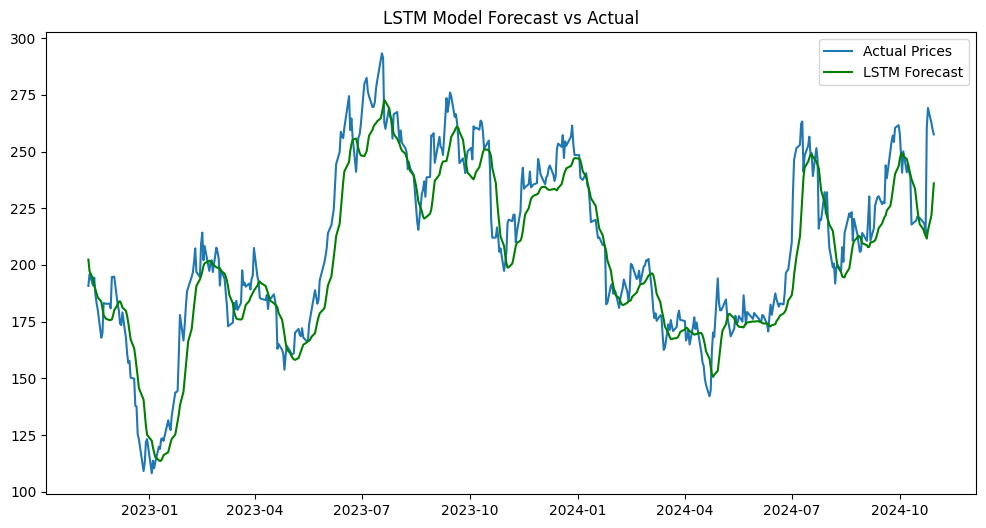

In [10]:
# Scale data for LSTM model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(np.array(train).reshape(-1, 1))

# Prepare data for LSTM training
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i])
    y_train.append(train_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Define LSTM model architecture
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

# Compile and train the LSTM model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare test data inputs for LSTM predictions
# Only the last 60 values of `train` are combined with `test`
inputs = scaler.transform(np.array(train.iloc[-60:, 0].tolist() + test.iloc[:, 0].tolist()).reshape(-1, 1))

# Create sequences for LSTM prediction
X_test = [inputs[i-60:i] for i in range(60, len(inputs))]
X_test = np.array(X_test)

# Make predictions using the trained model
lstm_forecast = model_lstm.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Rescale predictions to original scale

# Ensure the forecast and test data are aligned for plotting
# Use only the last `len(test)` elements of `lstm_forecast`
lstm_forecast = lstm_forecast[-len(test):]

# Plot the LSTM forecast against the actual prices
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Prices')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast', color='green')
plt.legend()
plt.title("LSTM Model Forecast vs Actual")
plt.show()


## Model Evaluation

In [11]:
# Define function to calculate evaluation metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = mean_squared_error(actual, forecast, squared=False)
    mape = mean_absolute_percentage_error(actual, forecast)
    return mae, rmse, mape

# Evaluate models
arima_mae, arima_rmse, arima_mape = calculate_metrics(test, arima_forecast)
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(test, sarima_forecast)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(test, lstm_forecast)

# Print metrics
print("ARIMA: MAE =", arima_mae, ", RMSE =", arima_rmse, ", MAPE =", arima_mape)
print("SARIMA: MAE =", sarima_mae, ", RMSE =", sarima_rmse, ", MAPE =", sarima_mape)
print("LSTM: MAE =", lstm_mae, ", RMSE =", lstm_rmse, ", MAPE =", lstm_mape)


ARIMA: MAE = 38.907052519827175 , RMSE = 49.1129918969654 , MAPE = 0.17612209105913845
SARIMA: MAE = 45.28501029435203 , RMSE = 55.68690557139644 , MAPE = 0.20261358137144486
LSTM: MAE = 10.877395968967013 , RMSE = 14.218953607352077 , MAPE = 0.05281042320050482
